In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed,SimpleRNN,Dropout,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import gc

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import sys
print (sys.version)
 # 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
print(tf.__version__)

3.9.20 (main, Oct  3 2024, 07:38:01) [MSC v.1929 64 bit (AMD64)]
2.8.0


In [ ]:
def dataReader():
    df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")
    df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")
    df_merged = pd.merge(df, df_truth, on='id')
    # Step 1: Get the maximum cycle for each engine
    max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
    max_cycle_per_engine.columns = ['id', 'max_cycle']

    # Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
    df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

    # Step 3: Calculate the actual failure cycle (when engine will fail)
    df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

    # Step 4: Merge this back with the main DataFrame to compute remaining cycles
    df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

    # Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
    df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
    df = df.drop('failure_cycle',axis=1)
    return df

In [4]:
df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")
df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")


In [5]:
df_merged = pd.merge(df, df_truth, on='id')
df_merged

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,more
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,98
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,98
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,98
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,98
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20426,99,181,-0.0015,-0.0001,100,518.67,643.72,1600.39,1428.03,14.62,...,2388.29,8123.55,8.4885,0.03,396,2388,100,38.50,23.0425,20
20427,99,182,-0.0027,-0.0003,100,518.67,643.52,1605.33,1430.32,14.62,...,2388.27,8130.99,8.5124,0.03,393,2388,100,38.39,22.9674,20
20428,99,183,-0.0031,-0.0003,100,518.67,643.96,1606.95,1427.90,14.62,...,2388.31,8126.90,8.5374,0.03,395,2388,100,38.57,23.1440,20
20429,99,184,-0.0010,-0.0001,100,518.67,644.10,1600.20,1436.54,14.62,...,2388.33,8125.66,8.5592,0.03,395,2388,100,38.45,23.0478,20


In [6]:
# Step 1: Get the maximum cycle for each engine
max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
max_cycle_per_engine.columns = ['id', 'max_cycle']

# Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

# Step 3: Calculate the actual failure cycle (when engine will fail)
df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

# Step 4: Merge this back with the main DataFrame to compute remaining cycles
df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

# Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
df = df.drop('failure_cycle',axis=1)

In [7]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,remaining_cycles
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,289
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,288
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,287
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,286
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,285


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20431 entries, 0 to 20430
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20431 non-null  int64  
 1   cycle             20431 non-null  int64  
 2   setting1          20431 non-null  float64
 3   setting2          20431 non-null  float64
 4   setting3          20431 non-null  int64  
 5   s1                20431 non-null  float64
 6   s2                20431 non-null  float64
 7   s3                20431 non-null  float64
 8   s4                20431 non-null  float64
 9   s5                20431 non-null  float64
 10  s6                20431 non-null  float64
 11  s7                20431 non-null  float64
 12  s8                20431 non-null  float64
 13  s9                20431 non-null  float64
 14  s10               20431 non-null  float64
 15  s11               20431 non-null  float64
 16  s12               20431 non-null  float6

In [9]:
def create_sequences_3(df, window_size=30, test_size=0.1, val_size=0.1):
    """
    Generates scaled sequences and splits into training, validation, and testing sets.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with engine data.
    window_size (int): Number of time steps in each sequence.
    test_size (float): Fraction of data to reserve for testing.
    val_size (float): Fraction of data to reserve for validation.

    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler (np.ndarray): 
    Arrays of train/val/test sequences and targets, feature and target scalers.
    """
    features = [col for col in df.columns if col not in ['id', 'cycle', 'remaining_cycles']]
    target_column = 'remaining_cycles'
    
    # Initialize scalers
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Lists to collect sequences and targets
    X_sequences = []
    y_targets = []
    
    # Group by engine ID and create sliding windows before splitting
    for engine_id, engine_data in df.groupby('id'):
        engine_data = engine_data.sort_values(by='cycle')  # Sort by cycle to keep temporal order
        
        # Create sliding windows
        for i in range(len(engine_data) - window_size):
            X_sequence = engine_data[features].iloc[i:i + window_size].values
            y_target = engine_data[target_column].iloc[i + window_size - 1]  # Target is RUL of last cycle in window
            
            X_sequences.append(X_sequence)
            y_targets.append(y_target)
    
    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    # Split data into training+validation and testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_sequences, y_targets, test_size=test_size, random_state=42)
    
    # Further split the training+validation data into training and validation
    val_ratio_adjusted = val_size / (1 - test_size)  # Adjust validation size proportionally
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio_adjusted, random_state=42)
    
    # Fit the scalers on the training data
    feature_scaler.fit(X_train.reshape(-1, X_train.shape[2]))  # Reshape for fitting scaler
    target_scaler.fit(y_train.reshape(-1, 1))  # Reshape target for fitting scaler
    
    # Apply the scalers to the data
    X_train = feature_scaler.transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)  # Reshape back after scaling
    X_val = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
    X_test = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
    
    y_train = target_scaler.transform(y_train.reshape(-1, 1))
    y_val = target_scaler.transform(y_val.reshape(-1, 1))
    y_test = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler


In [10]:
def plot_loss(history, title,lim=(None,None)):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.ylim(lim)
    plt.grid(True)
    plt.show()

In [11]:
# Adjusted evaluation function
def evaluate_model(model, X_test, y_test,type,scaler):
    predictions = model.predict(X_test)
    if predictions.shape[0] != y_test.shape[0]:
        # Trimming to the minimum size for consistency
        min_len = min(predictions.shape[0], y_test.shape[0])
        predictions = predictions[:min_len]
        y_test = y_test[:min_len]
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(predictions.reshape(-1,1))))
    mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(predictions.reshape(-1,1)))
    print(f"{type} Model Evaluation - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return predictions, rmse, mae

In [12]:
metrics_results = []
window_size = [10,15,20,25,30,35,40,45,50]
models = []
historys = []
num_features=24

In [13]:
for i in range(len(window_size)):
    X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=window_size[i], test_size=0.2)
    model = Sequential([
        GRU(64, return_sequences=True, input_shape=(window_size[i], num_features)),
        Dropout(0.3),
        GRU(32, return_sequences=True),
        Dropout(0.2),
        GRU(16, return_sequences=False),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),loss='mae',metrics=['mse'])
    # Train the model
    history = model.fit(X_train,y_train,
                        validation_data=(X_val,y_val),
                        epochs=200, batch_size=16,
                        callbacks=tf.keras.callbacks.EarlyStopping(patience=30,monitor='val_loss',restore_best_weights=True))
    historys.append(history)
    model.save(f'models/model_winLen{window_size[i]}.keras')
    # X_train, X_val, X_test, y_train, y_val, y_test, scaler,yscaler= create_sequences_3(df, window_size=window_size, test_size=0.2)
    metrics_results.append(evaluate_model(model, X_test,y_test,f'window_len {window_size[i]} model',yscaler))
    del model, X_train, X_val, X_test, y_train, y_val, y_test, history
    gc.collect()
    tf.keras.backend.clear_session()


Epoch 1/200
851/851 [==============================] - 44s 30ms/step - loss: 0.6145 - mse: 0.5933 - val_loss: 0.5983 - val_mse: 0.5683
Epoch 2/200
851/851 [==============================] - 24s 28ms/step - loss: 0.5973 - mse: 0.5649 - val_loss: 0.5871 - val_mse: 0.5514
Epoch 3/200
851/851 [==============================] - 25s 29ms/step - loss: 0.5863 - mse: 0.5490 - val_loss: 0.5856 - val_mse: 0.5588
Epoch 4/200
851/851 [==============================] - 26s 30ms/step - loss: 0.5720 - mse: 0.5315 - val_loss: 0.5635 - val_mse: 0.5364
Epoch 5/200
851/851 [==============================] - 28s 32ms/step - loss: 0.5582 - mse: 0.5141 - val_loss: 0.5570 - val_mse: 0.5106
Epoch 6/200
851/851 [==============================] - 26s 31ms/step - loss: 0.5358 - mse: 0.4849 - val_loss: 0.5267 - val_mse: 0.4784
Epoch 7/200
851/851 [==============================] - 26s 30ms/step - loss: 0.5108 - mse: 0.4473 - val_loss: 0.5183 - val_mse: 0.4768
Epoch 8/200
851/851 [==============================] - 

c:\Users\anush\.conda\envs\mlEnv_2\lib\site-packages\sklearn\preprocessing\_data.py:1020: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


Epoch 1/200
829/829 [==============================] - 18s 17ms/step - loss: 0.6148 - mse: 0.5921 - val_loss: 0.6061 - val_mse: 0.5661
Epoch 2/200
829/829 [==============================] - 12s 15ms/step - loss: 0.5986 - mse: 0.5649 - val_loss: 0.5817 - val_mse: 0.5405
Epoch 3/200
829/829 [==============================] - 12s 15ms/step - loss: 0.5842 - mse: 0.5446 - val_loss: 0.5721 - val_mse: 0.5458
Epoch 4/200
829/829 [==============================] - 12s 14ms/step - loss: 0.5601 - mse: 0.5095 - val_loss: 0.5421 - val_mse: 0.4794
Epoch 5/200
829/829 [==============================] - 12s 14ms/step - loss: 0.5315 - mse: 0.4726 - val_loss: 0.5061 - val_mse: 0.4335
Epoch 6/200
829/829 [==============================] - 12s 14ms/step - loss: 0.4896 - mse: 0.4132 - val_loss: 0.4967 - val_mse: 0.4363
Epoch 7/200
829/829 [==============================] - 12s 14ms/step - loss: 0.4504 - mse: 0.3627 - val_loss: 0.4380 - val_mse: 0.3430
Epoch 8/200
829/829 [==============================] - 

c:\Users\anush\.conda\envs\mlEnv_2\lib\site-packages\sklearn\preprocessing\_data.py:1020: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


Epoch 1/200
743/743 [==============================] - 18s 20ms/step - loss: 0.6223 - mse: 0.6048 - val_loss: 0.6108 - val_mse: 0.5854
Epoch 2/200
743/743 [==============================] - 14s 19ms/step - loss: 0.5983 - mse: 0.5666 - val_loss: 0.5661 - val_mse: 0.5216
Epoch 3/200
743/743 [==============================] - 14s 19ms/step - loss: 0.5505 - mse: 0.4995 - val_loss: 0.5173 - val_mse: 0.4743
Epoch 4/200
743/743 [==============================] - 14s 19ms/step - loss: 0.4800 - mse: 0.3946 - val_loss: 0.4386 - val_mse: 0.3495
Epoch 5/200
743/743 [==============================] - 14s 19ms/step - loss: 0.4115 - mse: 0.3030 - val_loss: 0.3724 - val_mse: 0.2743
Epoch 6/200
743/743 [==============================] - 14s 19ms/step - loss: 0.3469 - mse: 0.2268 - val_loss: 0.3450 - val_mse: 0.2265
Epoch 7/200
743/743 [==============================] - 14s 19ms/step - loss: 0.2902 - mse: 0.1634 - val_loss: 0.2540 - val_mse: 0.1288
Epoch 8/200
743/743 [==============================] - 

c:\Users\anush\.conda\envs\mlEnv_2\lib\site-packages\sklearn\preprocessing\_data.py:1020: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


Epoch 1/200
721/721 [==============================] - 17s 20ms/step - loss: 0.6241 - mse: 0.6021 - val_loss: 0.5930 - val_mse: 0.5524
Epoch 2/200
721/721 [==============================] - 13s 19ms/step - loss: 0.6009 - mse: 0.5730 - val_loss: 0.5608 - val_mse: 0.5164
Epoch 3/200
721/721 [==============================] - 14s 19ms/step - loss: 0.5588 - mse: 0.5144 - val_loss: 0.5110 - val_mse: 0.4480
Epoch 4/200
721/721 [==============================] - 13s 19ms/step - loss: 0.4690 - mse: 0.3854 - val_loss: 0.3867 - val_mse: 0.2626
Epoch 5/200
721/721 [==============================] - 14s 19ms/step - loss: 0.3753 - mse: 0.2524 - val_loss: 0.3530 - val_mse: 0.2161
Epoch 6/200
721/721 [==============================] - 13s 19ms/step - loss: 0.2967 - mse: 0.1622 - val_loss: 0.2346 - val_mse: 0.1058
Epoch 7/200
721/721 [==============================] - 13s 19ms/step - loss: 0.2401 - mse: 0.1080 - val_loss: 0.2109 - val_mse: 0.0773
Epoch 8/200
721/721 [==============================] - 

In [14]:
def plot_metrics_vs_window(results, window_lengths):
    """
    Plots MAE and RMSE vs. window lengths.
    
    Parameters:
        results (list of tuples): Each tuple contains (rmse, mae) for a model.
        window_lengths (list): List of window lengths corresponding to each result.
    """
    # Extract RMSE and MAE from results
    rmse_values = [result[1] for result in results]
    mae_values = [result[2] for result in results]
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(window_lengths, rmse_values, label="RMSE", marker='o', color='b')
    plt.plot(window_lengths, mae_values, label="MAE", marker='o', color='r')
    
    plt.title("Model Performance vs. Window Length")
    plt.xlabel("Window Length")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.show()

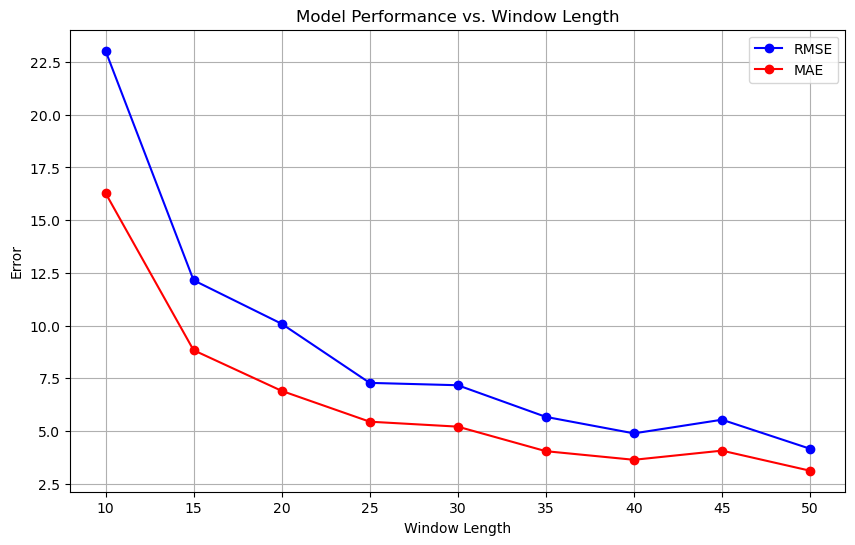

In [15]:
plot_metrics_vs_window(metrics_results, window_size)

In [22]:
import pickle

# Assuming 'history_array' is a list of history objects
with open('history_array.pkl', 'wb') as f:
    pickle.dump([h.history for h in historys], f)


In [23]:
with open('history_array.pkl', 'rb') as f:
    history_arrays = pickle.load(f)

# 'history_arrays' will now be a list of dictionaries, each containing the training history for each model
